# Bank Marketing Campaign
### Created By : Deni Rizky Rizaldi

## Business Problem & Data Understanding

## Business Problem Understanding

**Context**  
Berikut ini adalah kumpulan data yang menggambarkan hasil kampanye pemasaran bank. Kampanye yang dilakukan sebagian besar didasarkan pada panggilan telepon langsung, menawarkan klien bank untuk menempatkan deposito berjangka.
Jika setelah semua upaya penandaan klien telah setuju untuk menempatkan deposit - variabel target ditandai 'ya', jika tidak 'tidak'

Target :

Tidak (0)  : Tidak menempatkan deposit

Ya (1)  : Menempatkan deposit

**Problem Statement :**

Proses kampanye pemasaran bank memakan waktu dan sumber daya jika bank menargetkan semua nasabah tanpa melakukan penyaringan terlebih dahulu. Bank ingin meningkatkan efisiensi kampanye dengan mengetahui kandidat mana yang akan menempatkan depositnya ke bank.

Jika kampanye yang dilakukan kepada semua calon/kandidat depositor, maka waktu dan biaya tersebut akan sia-sia jika calon depositor tersebut tidak mau menempatkan uangnya di bank.

**Goals :**

Maka berdasarkan permasalahan tersebut, bank ingin memiliki kemampuan untuk memprediksi kemungkinan seorang kandidat akan/ingin menempatkan depositnya atau tidak, sehingga dapat memfokuskan kampanye pada kandidat yang bersedia menempatkan deposit ke bank.

Dan juga, perusahaan ingin mengetahui apa/faktor/variabel apa yang membuat seorang kandidat mau menempatkan deposito atau tidak, sehingga mereka dapat membuat rencana yang lebih baik dalam mendekati kandidat potensial (kandidat yang ingin menempatkan depostionya).

**Analytic Approach :**

Jadi yang akan kita lakukan adalah menganalisis data untuk menemukan pola yang membedakan kandidat yang mau menempatkan deposito atau tidak.

Kemudian kita akan membangun model klasifikasi yang akan membantu bank untuk dapat memprediksi probabilitas seorang kandidat akan/ingin menempatkan deposito atau tidak.

**Metric Evaluation**

Type 1 error : False Positive  
Konsekuensi: sia-sianya biaya kampanye, waktu dan sumber daya

Type 2 error : False Negative  
Konsekuensi: kehilangan calon depositor

Berdasarkan konsekuensinya, maka sebisa mungkin yang akan kita lakukan adalah membuat model yang dapat mengurangi cost kampanye dari bank tersebut, tetapi tanpa membuat menjadi kurangnya/tidak cukup kandidat depositor yang dibutuhkan bank. Jadi harus kita seimbangkan nanti antara precision dan recallnya dari kelas positive (kandidat depositor). Jadi nanti metric utama yang akan kita gunakan adalah roc_auc.

## Data Understanding

Sumber Dataset : https://drive.google.com/drive/folders/1RbARQXmF64lrOV-RSBhLa5vKk0vBVMEf

Note : 
- Sebagian besar fitur bersifat kategori (Nominal, Ordinal, Binary)
- Setiap baris data merepresentasikan informasi seorang customer yang pernah dilakukan bank campaign di masa lalu

### Attribute Information

| Atribut/Feature | Tipe Data | Deskripsi |
| --- | --- | --- |
| age | numeric | Umur customer
| job | categorical | Tipe-tipe job
| balance | numeric | Rata-rata balance tahunan |
| housing | binary | Memiliki cicilan rumah
| loan | binary | Memiliki hutang personal
| contact | categorical | Tipe kontak komunikasi
| month | categorical | Kontak terakir dalam setahun
| campaign | numeric | Jumlah kontak yang dilakukan selama kampanye
| pdays | numeric | Jumlah hari berlalu setelah customer terakhir dihubungi dari kammpanye sebelumnya
| poutcome | categorical | Hasil dari kampanye pemasaran sebelumnya
| deposit | binary | customer berlangganan deposit berjangka

In [2]:
# Library

import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
from IPython.display import display

# Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
import category_encoders as ce

# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
# import lightgbm as lgb
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve

# Imbalance Dataset
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Set max columns
pd.set_option('display.max_columns', None)

# Model
import pickle
import joblib

In [3]:
#Load Dataset
df = pd.read_csv("data_bank_marketing_campaign.csv")
df.head()

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit
0,55,admin.,1662,no,no,cellular,jun,2,-1,unknown,yes
1,39,self-employed,-3058,yes,yes,cellular,apr,3,-1,unknown,yes
2,51,admin.,3025,no,no,cellular,may,1,352,other,yes
3,38,services,-87,yes,no,cellular,may,1,-1,unknown,no
4,36,housemaid,205,yes,no,telephone,nov,4,-1,unknown,no


In [4]:
# Count and Datatype for each Column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813 entries, 0 to 7812
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       7813 non-null   int64 
 1   job       7813 non-null   object
 2   balance   7813 non-null   int64 
 3   housing   7813 non-null   object
 4   loan      7813 non-null   object
 5   contact   7813 non-null   object
 6   month     7813 non-null   object
 7   campaign  7813 non-null   int64 
 8   pdays     7813 non-null   int64 
 9   poutcome  7813 non-null   object
 10  deposit   7813 non-null   object
dtypes: int64(4), object(7)
memory usage: 671.6+ KB


## Data Cleaning

Tidak ada data yang hilang/kosong, semua feature bisa digunakan dan siap pakai untuk melakukan analisa terhadap masalah dan juga pembuatan model machine learningnya.

In [5]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,age,int64,0,0.0,75,"[85, 27]"
1,job,object,0,0.0,12,"[unemployed, housemaid]"
2,balance,int64,0,0.0,3153,"[4500, 665]"
3,housing,object,0,0.0,2,"[yes, no]"
4,loan,object,0,0.0,2,"[no, yes]"
5,contact,object,0,0.0,3,"[telephone, unknown]"
6,month,object,0,0.0,12,"[oct, mar]"
7,campaign,int64,0,0.0,32,"[20, 10]"
8,pdays,int64,0,0.0,422,"[776, 223]"
9,poutcome,object,0,0.0,4,"[other, success]"


Data tipe yang ada susah sesuai dengan featurenya, jadi tidak perlu merubah tipe data, dan lanjut ke tahap Analisa Datanya untuk keperluan masalah yang dihadapi.

## Data Analysis

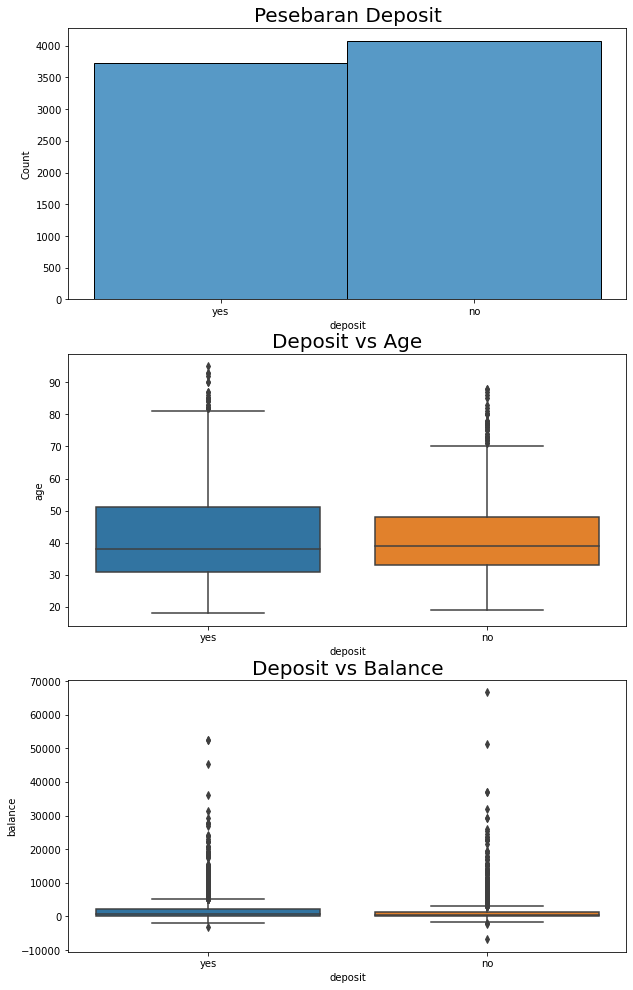

In [6]:
plt.figure(figsize=(10,17))

plt.subplot(311)
sns.histplot(data=df,x='deposit')
plt.title('Pesebaran Deposit',fontsize=20)

plt.subplot(312)
sns.boxplot(data=df, x='deposit', y ='age')
plt.title('Deposit vs Age',fontsize=20)

plt.subplot(313)
sns.boxplot(data=df, x='deposit', y ='balance')
plt.title('Deposit vs Balance',fontsize=20)

plt.show()

Berdasarkan plot diatas, dapat kita simpulkan bahwa :

1. Pesebaran data customer yang deposit atau tidak seimbang, jadi tidak diperlukan handling imbalance
2. Usia customer yang melakukan deposit atau tidak yakni sama, sekitar di rentang 40 tahunan
3. Pada grafik Deposit vs Balance, terdapat outliers baik pada customer yang melakukan deposit atau tidak, namun disini tidak akan dihapus untuk outliersnya, dikarenakan terlalu banyak jumlahnya. 

Sekarang mari kita siapkan data kita untuk pembuatan model machine learning

## Data Preparation & Feature Engineering

In [7]:
df.head()

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit
0,55,admin.,1662,no,no,cellular,jun,2,-1,unknown,yes
1,39,self-employed,-3058,yes,yes,cellular,apr,3,-1,unknown,yes
2,51,admin.,3025,no,no,cellular,may,1,352,other,yes
3,38,services,-87,yes,no,cellular,may,1,-1,unknown,no
4,36,housemaid,205,yes,no,telephone,nov,4,-1,unknown,no


Sekarang mari kita melakukan fitur encoding untuk fitur-fitur categorical yang kita miliki.
Yang akan kita lakukan adalah :

1. Merubah fitur/kolom `job` menggunakan One Hot Encoding, karena fitur ini tidak memiliki urutan/tidak ordinal, dan juga jumlah unique datanya hanya sedikit.

1. Merubah fitur/kolom `housing` menggunakan One Hot Encoding, karena fitur ini tidak memiliki urutan/tidak ordinal, dan juga jumlah unique datanya hanya sedikit.

1. Merubah fitur/kolom `loan` menggunakan One Hot Encoding, karena fitur ini tidak memiliki urutan/tidak ordinal, dan juga jumlah unique datanya hanya sedikit.

1. Merubah fitur/kolom `contact` menggunakan One Hot Encoding, karena fitur ini tidak memiliki urutan/tidak ordinal, dan juga jumlah unique datanya hanya sedikit.

1. Merubah fitur/kolom `month` menggunakan One Hot Encoding, karena fitur ini tidak memiliki urutan/tidak ordinal, dan juga jumlah unique datanya hanya sedikit.

1. Merubah fitur/kolom `poutcome` menggunakan One Hot Encoding, karena fitur ini tidak memiliki urutan/tidak ordinal, dan juga jumlah unique datanya hanya sedikit.

In [8]:
transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first'), ['job', 'housing', 'loan', 'contact', 'month', 'poutcome']),
], remainder='passthrough')

In [9]:
x = df.drop(columns=['deposit'])
y = df['deposit']

In [10]:
x_train,x_test,y_train,y_test=train_test_split(x,y,stratify=y,test_size=0.2,random_state=2022)

In [11]:
x_train_preprocessed = transformer.fit_transform(x_train).toarray()
x_train_preprocessed

array([[ 0.000e+00,  0.000e+00,  0.000e+00, ...,  1.076e+03,  1.000e+00,
         9.600e+01],
       [ 0.000e+00,  0.000e+00,  0.000e+00, ...,  2.488e+03,  1.000e+00,
        -1.000e+00],
       [ 0.000e+00,  1.000e+00,  0.000e+00, ..., -7.010e+02,  2.000e+00,
        -1.000e+00],
       ...,
       [ 0.000e+00,  0.000e+00,  0.000e+00, ...,  0.000e+00,  1.000e+00,
        -1.000e+00],
       [ 0.000e+00,  0.000e+00,  0.000e+00, ...,  7.050e+02,  2.000e+00,
         3.500e+01],
       [ 0.000e+00,  0.000e+00,  0.000e+00, ...,  3.710e+02,  1.000e+00,
        -1.000e+00]])

In [12]:
testing = pd.DataFrame(x_train_preprocessed, columns = transformer.get_feature_names())
testing.dropna()

,onehot__x0_blue-collar,onehot__x0_entrepreneur,onehot__x0_housemaid,onehot__x0_management,onehot__x0_retired,onehot__x0_self-employed,onehot__x0_services,onehot__x0_student,onehot__x0_technician,onehot__x0_unemployed,onehot__x0_unknown,onehot__x1_yes,onehot__x2_yes,onehot__x3_telephone,onehot__x3_unknown,onehot__x4_aug,onehot__x4_dec,onehot__x4_feb,onehot__x4_jan,onehot__x4_jul,onehot__x4_jun,onehot__x4_mar,onehot__x4_may,onehot__x4_nov,onehot__x4_oct,onehot__x4_sep,onehot__x5_other,onehot__x5_success,onehot__x5_unknown,age,balance,campaign,pdays
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,33.0,1076.0,1.0,96.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,21.0,2488.0,1.0,-1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,49.0,-701.0,2.0,-1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,35.0,1330.0,1.0,-1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,30.0,0.0,1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,32.0,-1.0,2.0,-1.0
6246,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,29.0,502.0,2.0,199.0
6247,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,34.0,0.0,1.0,-1.0
6248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,705.0,2.0,35.0


## Modeling & Evaluation

In [18]:
logreg = LogisticRegression()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()

### Model Benchmarking : K-Fold

In [14]:
models = [logreg,knn,dt,rf]
score=[]
rata=[]
std=[]

for i in models:
    skfold=StratifiedKFold(n_splits=5)
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',i)])
    model_cv=cross_val_score(estimator,x_train,y_train,cv=skfold,scoring='roc_auc')
    score.append(model_cv)
    rata.append(model_cv.mean())
    std.append(model_cv.std())
    
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest'],'mean roc_auc':rata,'sdev':std}).set_index('model').sort_values(by='mean roc_auc',ascending=False)

,mean roc_auc,sdev
model,,
Random Forest,0.759480,0.020570
Logistic Regression,0.738488,0.025022
Decision Tree,0.623617,0.011713
KNN,0.611845,0.010752


Terlihat bahwa model Random Forest adalah yang terbaik untuk roc_aucnya dari setiap model yang menggunakan default hyperparameter

### Model Benchmarking : Test Data

In [15]:
models = [logreg,knn,dt,rf]
score_roc_auc = []

def y_pred_func(i):
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',i)])
    x_train,x_test
    
    estimator.fit(x_train,y_train)
    return(estimator,estimator.predict(x_test),x_test)

for i,j in zip(models, ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest']):
    estimator,y_pred,x_test = y_pred_func(i)
    y_predict_proba = estimator.predict_proba(x_test)[:,1]
    score_roc_auc.append(roc_auc_score(y_test,y_predict_proba))
    print(j,'\n', classification_report(y_test,y_pred))
    
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest'],
             'roc_auc score':score_roc_auc}).set_index('model').sort_values(by='roc_auc score',ascending=False)

Logistic Regression 
               precision    recall  f1-score   support

          no       0.70      0.74      0.72       816
         yes       0.69      0.66      0.67       747

    accuracy                           0.70      1563
   macro avg       0.70      0.70      0.70      1563
weighted avg       0.70      0.70      0.70      1563

KNN 
               precision    recall  f1-score   support

          no       0.60      0.62      0.61       816
         yes       0.57      0.54      0.55       747

    accuracy                           0.58      1563
   macro avg       0.58      0.58      0.58      1563
weighted avg       0.58      0.58      0.58      1563

Decision Tree 
               precision    recall  f1-score   support

          no       0.64      0.62      0.63       816
         yes       0.60      0.62      0.61       747

    accuracy                           0.62      1563
   macro avg       0.62      0.62      0.62      1563
weighted avg       0.62      0

,roc_auc score
model,
Logistic Regression,0.761722
Random Forest,0.758961
Decision Tree,0.623606
KNN,0.614486


Terlihat kembali lagi model Random Forest adalah yang terbaik performanya pada test data. Maka untuk model yang akan di Pickle adalah RandomForestClassifier

## Prediction : Pickle

In [16]:
# definisikan kembali estimator final yang akan digunakan yaitu Pipeline dengan model RandomForestClassifier
estimator_final = Pipeline([
        ('preprocess',transformer),
        ('model',rf)])

# estimator di training kembali
estimator_final.fit(x_train, y_train)

# Model Pickling
filename = 'Model_Final_rf.sav'
pickle.dump(estimator_final, open(filename,'wb'))

# # load dataset
# bank_campaign = pd.read_csv('data_bank_marketing_campaign.csv')

# # load model
# filename = 'Model Final.sav'
# loaded_model = pickle.load(open(filename,'rb'))

### Conclusion & Recommendation

In [17]:
print('Classification Report Random Forest : \n', classification_report(y_test,y_pred))

Classification Report Random Forest : 
               precision    recall  f1-score   support

          no       0.70      0.75      0.72       816
         yes       0.70      0.65      0.67       747

    accuracy                           0.70      1563
   macro avg       0.70      0.70      0.70      1563
weighted avg       0.70      0.70      0.70      1563



Berdasarkan hasil classification report dari model kita, kita dapat menyimpulkan/mengambil konklusi bahwa bila seandainya nanti kita menggunakan model kita untuk memfilter/menyaring list customer yang akan kita coba tawarkan, maka model kita dapat mengurangi 74% customer yang tidak tertarik untuk tidak kita approach, dan model kita dapat mendapatkan 65% customer yang tertarik dari seluruh customer yang tertarik melakukan deposit. (semua ini berdasarkan recallnya)

Model kita ini memiliki ketepatan prediksi customer yang tertarik melakukan deposito sebesar 70% (precisionnya), jadi setiap model kita memprediksi bahwa seorang customer itu tertarik, maka kemungkinan tebakannya benar itu sebesar 70% kurang lebih. Maka masih akan ada customer yang sebenarnya tidak tertarik tetapi diprediksi sebagai customer yang tertarik sekitar 26% dari keseluruhan kandidat yang tidak tertarik (berdasarkan recall).

Berdasarkan analisa tersebut, terlihat bahwa dengan menggunakan model kita, maka bank bisa menghemat biaya yang cukup besar tanpa mengorbankan terlalu banyak jumlah customer potensial yg tertarik.

#### Recommendation

Hal-hal yang bisa dilakukan untuk mengembangkan project dan modelnya lebih baik lagi :

- Memperbaiki modelling dari sebelumnya atau melakukan improvement dari model yang sudah dibuat.
- Menambahkan fitur2 atau kolom2 baru yang kemungkinan bisa berhubungan dengan ketertarikannya, seperti status perkawinan, tingkat edukasi, dan lainnya.
- Mencoba algorithm ML yang lain dan juga mencoba hyperparameter tuning kembali.
- Menganalisa data-data yang model kita masih salah tebak untuk mengetahui alasannya dan karakteristiknya bagaimana.

# Goodluck & Thank You